# Self Consistent Training Model For The Hybrid Autoencoder

### Library imports.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
import numpy as np
import math
import os

import strawberryfields as sf
from strawberryfields import ops
sf.about()

from matplotlib.pyplot import figure
figure(figsize=(12, 6), dpi=100)


Strawberry Fields: a Python library for continuous-variable quantum circuits.
Copyright 2018-2020 Xanadu Quantum Technologies Inc.

Python version:            3.9.7
Platform info:             Windows-10-10.0.22000-SP0
Installation path:         C:\Users\Bartu\anaconda3\envs\qml\lib\site-packages\strawberryfields
Strawberry Fields version: 0.23.0
Numpy version:             1.22.2
Scipy version:             1.8.0
SymPy version:             1.9
NetworkX version:          2.6.3
The Walrus version:        0.18.0
Blackbird version:         0.4.0
XCC version:               0.2.1
TensorFlow version:        2.8.0


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

### Training parameter definitions.

In [2]:
# Number of modes
modes = 1

# Cutoff dimension (number of Fock states)
cutoff_dim = 5

# Input vector length.
input_len = 5

# Number of layers (depth)
Qlayers = 25

# Number of steps in optimization routine performing gradient descent for the quantum decoder.
reps = 200

# Learning rate
lr = 0.01

# Standard deviation of initial parameters
passive_sd = 0.2
active_sd = 0.01

# The gamma parameter in the penalty function, given by the reference paper.
norm_weight = 200

# Seeds for the RNG functions to be able to reproduce results.
tf.random.set_seed(155)
np.random.seed(155)

# Number of iterations to train the classical autoencoder.
classical_epochs = 100
# Number of feedback loop iterations.
sctm_iterations = 3

# Phase space circile restriciton radius.
alpha_clip = 5

save_folder_name = str(input_len) + '_inputs_sctm'
os.makedirs(save_folder_name, exist_ok=True)

train_state_select = 0

### Initialization of the classical encoder and decoder networks.

In [3]:
latent_dim = 2

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(input_len, activation ="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(5, activation="elu"),
      layers.Dense(4, activation="elu"),
      layers.Dense(3, activation="elu"),
      layers.Dense(latent_dim, activation="elu"),
    ])
    
    self.decoder = tf.keras.Sequential([
        layers.Dense(input_len, activation="elu"),
        layers.Dense(3, activation="elu"),
        layers.Dense(4, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(5, activation="elu"),
        layers.Dense(4, activation="elu"),
        layers.Dense(3, activation="elu"),
        layers.Dense(input_len, activation="elu")
    ])
    

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

### Initialization of layer weights.

In [4]:
def init_weights(modes, layers, active_sd=0.0001, passive_sd=0.1):
    """Initialize a 2D TensorFlow Variable containing normally-distributed
    random weights for an ``N`` mode quantum neural network with ``L`` layers.

    Args:
        modes (int): the number of modes in the quantum neural network
        layers (int): the number of layers in the quantum neural network
        active_sd (float): the standard deviation used when initializing
            the normally-distributed weights for the active parameters
            (displacement, squeezing, and Kerr magnitude)
        passive_sd (float): the standard deviation used when initializing
            the normally-distributed weights for the passive parameters
            (beamsplitter angles and all gate phases)

    Returns:
        tf.Variable[tf.float32]: A TensorFlow Variable of shape
        ``[layers, 2*(max(1, modes-1) + modes**2 + modes)]``, where the Lth
        row represents the layer parameters for the Lth layer.
    """
    # Number of interferometer parameters:
    M = int(modes * (modes - 1)) + max(1, modes - 1)

    # Create the TensorFlow variables
    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    dp_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat(
        [int1_weights, s_weights, int2_weights, dr_weights, dp_weights, k_weights], axis=1
    )

    weights = tf.Variable(weights)

    return weights

In [5]:
autoencoder = Autoencoder(latent_dim)

In [6]:
def GenerateTargetState(input_len, f):
    state = np.zeros(input_len)
    state[f] = 1.0
    train = np.array([state])
    return train, state
    
    
x_train, target_state = GenerateTargetState(input_len, train_state_select)
print('The target state for the training is chosen to be ' + str(target_state))

The target state for the training is chosen to be [1. 0. 0. 0. 0.]


### Compile the classical autoencoder.

In [7]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

### Initialization of the feedback loop that contains the training of the classical and quantum layers.

In [8]:
fid_progress = [[], [], [], [], [], [], []]
loss_progress = [[], [], [], [], [], [], []]


for j in range(sctm_iterations):
    history = autoencoder.fit(x_train, x_train,epochs=classical_epochs)
    
    encoded_st = autoencoder.encoder(np.array([target_state])).numpy()
    #decoded_st = autoencoder.decoder(encoded_st).numpy()
    
    def layer(params, q):
        """CV quantum neural network layer acting on ``N`` modes.

        Args:
            params (list[float]): list of length ``2*(max(1, N-1) + N**2 + n)`` containing
                the number of parameters for the layer
            q (list[RegRef]): list of Strawberry Fields quantum registers the layer
                is to be applied to
        """
        ops.Dgate(tf.clip_by_value(encoded_st[0][0], clip_value_min = -alpha_clip, clip_value_max = alpha_clip), math.degrees(encoded_st[0][1])) | q[0]

        N = len(q)
        M = int(N * (N - 1)) + max(1, N - 1)

        rphi = params[-N+1:]
        s = params[M:M+N]
        dr = params[2*M+N:2*M+2*N]
        dp = params[2*M+2*N:2*M+3*N]
        k = params[2*M+3*N:2*M+4*N]

        ops.Rgate(rphi[0]) | q[0]

        for i in range(N):
            ops.Sgate(s[i]) | q[i]

        ops.Rgate(rphi[0]) | q[0]

        for i in range(N):
            ops.Dgate(dr[i], dp[i]) | q[i]
            ops.Kgate(k[i]) | q[i]
    
    # initialize engine and program
    eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
    qnn = sf.Program(modes)

    # initialize QNN weights
    weights = init_weights(modes, Qlayers) # our TensorFlow weights
    num_params = np.prod(weights.shape)   # total number of parameters in our model

    # Create array of Strawberry Fields symbolic gate arguments, matching
    # the size of the weights Variable.
    sf_params = np.arange(num_params).reshape(weights.shape).astype(np.str)
    sf_params = np.array([qnn.params(*i) for i in sf_params])


    # Construct the symbolic Strawberry Fields program by
    # looping and applying layers to the program.
    with qnn.context as q:
        for k in range(Qlayers):
            layer(sf_params[k], q)
            
    def cost(weights):
        # Create a dictionary mapping from the names of the Strawberry Fields
        # free parameters to the TensorFlow weight values.
        mapping = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))}

        # Run engine
        state = eng.run(qnn, args=mapping).state

        # Extract the statevector
        ket = state.ket()

        # Compute the fidelity between the output statevector
        # and the target state.
        fidelity = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state)) ** 2

        # Objective function to minimize
        #cost = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state) - 1)
        #return cost, fidelity, ket
        # Instead of the Cost function, maybe it is better to break it down to components
        # at least, when the Fock basis is insufficent, it will be visible
        difference = tf.reduce_sum(tf.abs(ket - target_state))
        fidelity = tf.abs(tf.reduce_sum(tf.math.conj(ket) * target_state)) ** 2
        return difference, fidelity, ket, tf.math.real(state.trace())
    
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    
    fidp = []
    lossp = []
    best_fid = 0

    for i in range(reps):
        # reset the engine if it has already been executed
        if eng.run_progs:
            eng.reset()

        with tf.GradientTape() as tape:
            loss, fid, ket, trace = cost(weights)

        # Stores fidelity at each step
        fidp.append(fid.numpy())
        lossp.append(loss)

        if fid > best_fid:
            # store the new best fidelity and best state
            best_fid = fid.numpy()
            learnt_state = ket.numpy()

        # one repetition of the optimization
        gradients = tape.gradient(loss, weights)
        opt.apply_gradients(zip([gradients], [weights]))
         # Prints progress at every rep
        if i % 1 == 0:
            print("Rep: {} Cost: {:.4f} Fidelity: {:.4f} Trace: {:.4f}".format(i, loss, fid, trace))
            
    fid_progress[j] = fidp
    loss_progress[j] = lossp

    x_train = np.array([learnt_state])

Epoch 1/100
1/1 [==============================] - 1s 891ms/step - loss: 0.1906
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1875
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1845
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1816
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1788
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1761
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1735
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1710
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1685
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1661
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1637
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1614
Epoch 13/100
1/1 [==============================] - 0s 2ms/

C:\Users\Bartu\AppData\Local\Temp\ipykernel_13352\2927410443.py:52: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Rep: 0 Cost: 1.2257 Fidelity: 0.0039 Trace: 0.0214
Rep: 1 Cost: 1.1691 Fidelity: 0.0054 Trace: 0.0191
Rep: 2 Cost: 1.1427 Fidelity: 0.0074 Trace: 0.0177
Rep: 3 Cost: 1.0594 Fidelity: 0.0101 Trace: 0.0172
Rep: 4 Cost: 1.0121 Fidelity: 0.0126 Trace: 0.0169
Rep: 5 Cost: 1.0102 Fidelity: 0.0131 Trace: 0.0157
Rep: 6 Cost: 0.9421 Fidelity: 0.0134 Trace: 0.0142
Rep: 7 Cost: 0.9381 Fidelity: 0.0126 Trace: 0.0131
Rep: 8 Cost: 0.9670 Fidelity: 0.0116 Trace: 0.0124
Rep: 9 Cost: 0.9532 Fidelity: 0.0111 Trace: 0.0118
Rep: 10 Cost: 0.9458 Fidelity: 0.0108 Trace: 0.0116
Rep: 11 Cost: 0.9561 Fidelity: 0.0109 Trace: 0.0119
Rep: 12 Cost: 0.9515 Fidelity: 0.0115 Trace: 0.0122
Rep: 13 Cost: 0.9285 Fidelity: 0.0125 Trace: 0.0129
Rep: 14 Cost: 0.9198 Fidelity: 0.0132 Trace: 0.0135
Rep: 15 Cost: 0.9122 Fidelity: 0.0137 Trace: 0.0139
Rep: 16 Cost: 0.9187 Fidelity: 0.0139 Trace: 0.0143
Rep: 17 Cost: 0.9205 Fidelity: 0.0138 Trace: 0.0143
Rep: 18 Cost: 0.9183 Fidelity: 0.0140 Trace: 0.0146
Rep: 19 Cost: 0.9158 F

Rep: 157 Cost: 0.0994 Fidelity: 0.9375 Trace: 0.9390
Rep: 158 Cost: 0.1120 Fidelity: 0.9384 Trace: 0.9403
Rep: 159 Cost: 0.1432 Fidelity: 0.9483 Trace: 0.9503
Rep: 160 Cost: 0.0690 Fidelity: 0.9482 Trace: 0.9487
Rep: 161 Cost: 0.2532 Fidelity: 0.9315 Trace: 0.9371
Rep: 162 Cost: 0.2373 Fidelity: 0.9332 Trace: 0.9386
Rep: 163 Cost: 0.0813 Fidelity: 0.9495 Trace: 0.9504
Rep: 164 Cost: 0.1511 Fidelity: 0.9521 Trace: 0.9555
Rep: 165 Cost: 0.1072 Fidelity: 0.9477 Trace: 0.9507
Rep: 166 Cost: 0.0933 Fidelity: 0.9456 Trace: 0.9472
Rep: 167 Cost: 0.0960 Fidelity: 0.9476 Trace: 0.9487
Rep: 168 Cost: 0.1070 Fidelity: 0.9504 Trace: 0.9521
Rep: 169 Cost: 0.0918 Fidelity: 0.9523 Trace: 0.9545
Rep: 170 Cost: 0.1112 Fidelity: 0.9535 Trace: 0.9546
Rep: 171 Cost: 0.0977 Fidelity: 0.9494 Trace: 0.9516
Rep: 172 Cost: 0.1182 Fidelity: 0.9505 Trace: 0.9525
Rep: 173 Cost: 0.1148 Fidelity: 0.9565 Trace: 0.9581
Rep: 174 Cost: 0.0760 Fidelity: 0.9547 Trace: 0.9556
Rep: 175 Cost: 0.1091 Fidelity: 0.9513 Trace: 

C:\Users\Bartu\AppData\Local\Temp\ipykernel_13352\2927410443.py:52: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Rep: 0 Cost: 1.0892 Fidelity: 0.0001 Trace: 0.0034
Rep: 1 Cost: 1.0758 Fidelity: 0.0003 Trace: 0.0025
Rep: 2 Cost: 1.0680 Fidelity: 0.0003 Trace: 0.0024
Rep: 3 Cost: 1.0561 Fidelity: 0.0004 Trace: 0.0019
Rep: 4 Cost: 1.0435 Fidelity: 0.0004 Trace: 0.0015
Rep: 5 Cost: 1.0437 Fidelity: 0.0004 Trace: 0.0015
Rep: 6 Cost: 1.0369 Fidelity: 0.0005 Trace: 0.0015
Rep: 7 Cost: 1.0280 Fidelity: 0.0007 Trace: 0.0015
Rep: 8 Cost: 1.0230 Fidelity: 0.0008 Trace: 0.0017
Rep: 9 Cost: 1.0147 Fidelity: 0.0011 Trace: 0.0018
Rep: 10 Cost: 1.0055 Fidelity: 0.0013 Trace: 0.0019
Rep: 11 Cost: 0.9950 Fidelity: 0.0015 Trace: 0.0020
Rep: 12 Cost: 0.9913 Fidelity: 0.0018 Trace: 0.0021
Rep: 13 Cost: 0.9797 Fidelity: 0.0022 Trace: 0.0024
Rep: 14 Cost: 0.9747 Fidelity: 0.0025 Trace: 0.0026
Rep: 15 Cost: 0.9709 Fidelity: 0.0026 Trace: 0.0027
Rep: 16 Cost: 0.9631 Fidelity: 0.0029 Trace: 0.0030
Rep: 17 Cost: 0.9593 Fidelity: 0.0030 Trace: 0.0031
Rep: 18 Cost: 0.9574 Fidelity: 0.0035 Trace: 0.0035
Rep: 19 Cost: 0.9510 F

Rep: 157 Cost: 0.1212 Fidelity: 0.9322 Trace: 0.9343
Rep: 158 Cost: 0.1124 Fidelity: 0.9334 Trace: 0.9343
Rep: 159 Cost: 0.0980 Fidelity: 0.9318 Trace: 0.9329
Rep: 160 Cost: 0.1052 Fidelity: 0.9346 Trace: 0.9362
Rep: 161 Cost: 0.1059 Fidelity: 0.9372 Trace: 0.9382
Rep: 162 Cost: 0.0911 Fidelity: 0.9331 Trace: 0.9339
Rep: 163 Cost: 0.0866 Fidelity: 0.9326 Trace: 0.9338
Rep: 164 Cost: 0.1091 Fidelity: 0.9326 Trace: 0.9351
Rep: 165 Cost: 0.0961 Fidelity: 0.9342 Trace: 0.9360
Rep: 166 Cost: 0.0671 Fidelity: 0.9347 Trace: 0.9351
Rep: 167 Cost: 0.0908 Fidelity: 0.9362 Trace: 0.9375
Rep: 168 Cost: 0.0841 Fidelity: 0.9379 Trace: 0.9391
Rep: 169 Cost: 0.0839 Fidelity: 0.9368 Trace: 0.9372
Rep: 170 Cost: 0.0980 Fidelity: 0.9351 Trace: 0.9365
Rep: 171 Cost: 0.0952 Fidelity: 0.9355 Trace: 0.9366
Rep: 172 Cost: 0.1004 Fidelity: 0.9383 Trace: 0.9396
Rep: 173 Cost: 0.0915 Fidelity: 0.9367 Trace: 0.9376
Rep: 174 Cost: 0.0861 Fidelity: 0.9379 Trace: 0.9389
Rep: 175 Cost: 0.0728 Fidelity: 0.9387 Trace: 

Rep: 112 Cost: 0.6347 Fidelity: 0.2097 Trace: 0.2120
Rep: 113 Cost: 0.5966 Fidelity: 0.2304 Trace: 0.2327
Rep: 114 Cost: 0.5693 Fidelity: 0.2575 Trace: 0.2604
Rep: 115 Cost: 0.5749 Fidelity: 0.2748 Trace: 0.2788
Rep: 116 Cost: 0.5070 Fidelity: 0.2892 Trace: 0.2899
Rep: 117 Cost: 0.5095 Fidelity: 0.3207 Trace: 0.3228
Rep: 118 Cost: 0.5267 Fidelity: 0.3310 Trace: 0.3345
Rep: 119 Cost: 0.4906 Fidelity: 0.3770 Trace: 0.3803
Rep: 120 Cost: 0.4471 Fidelity: 0.3990 Trace: 0.4013
Rep: 121 Cost: 0.4198 Fidelity: 0.4444 Trace: 0.4471
Rep: 122 Cost: 0.4503 Fidelity: 0.4491 Trace: 0.4545
Rep: 123 Cost: 0.3632 Fidelity: 0.5090 Trace: 0.5108
Rep: 124 Cost: 0.3726 Fidelity: 0.5423 Trace: 0.5449
Rep: 125 Cost: 0.3440 Fidelity: 0.5699 Trace: 0.5715
Rep: 126 Cost: 0.3067 Fidelity: 0.5982 Trace: 0.6000
Rep: 127 Cost: 0.3622 Fidelity: 0.6347 Trace: 0.6431
Rep: 128 Cost: 0.2920 Fidelity: 0.6476 Trace: 0.6504
Rep: 129 Cost: 0.3103 Fidelity: 0.6533 Trace: 0.6609
Rep: 130 Cost: 0.3007 Fidelity: 0.6926 Trace: 

### Produce fidelity plot.

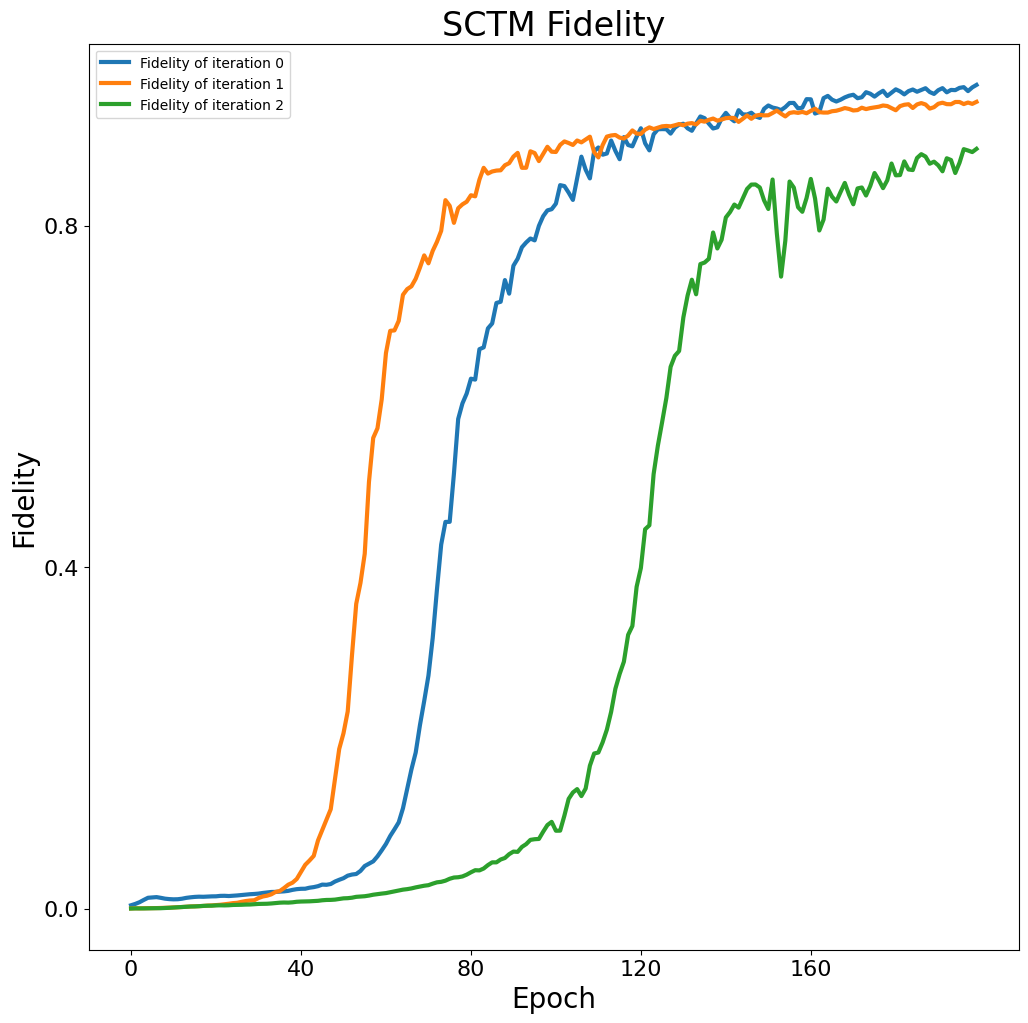

In [9]:
fig, ax = plt.subplots(figsize=(12, 12), dpi = 100)

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

for i in range(sctm_iterations):
    plt.plot(fid_progress[i], label = "Fidelity of iteration " + str(i), linewidth = 3)

plt.ylabel("Fidelity", fontsize = '20')
ax.yaxis.set_ticks(np.arange(0, 1, 0.4))
plt.xlabel("Epoch", fontsize = '20')
ax.xaxis.set_ticks(np.arange(0, reps, 40))
plt.title('SCTM Fidelity', fontsize = '24')
plt.legend()
plt.savefig('SCTM_fidelity.png')

### Produce loss plot.

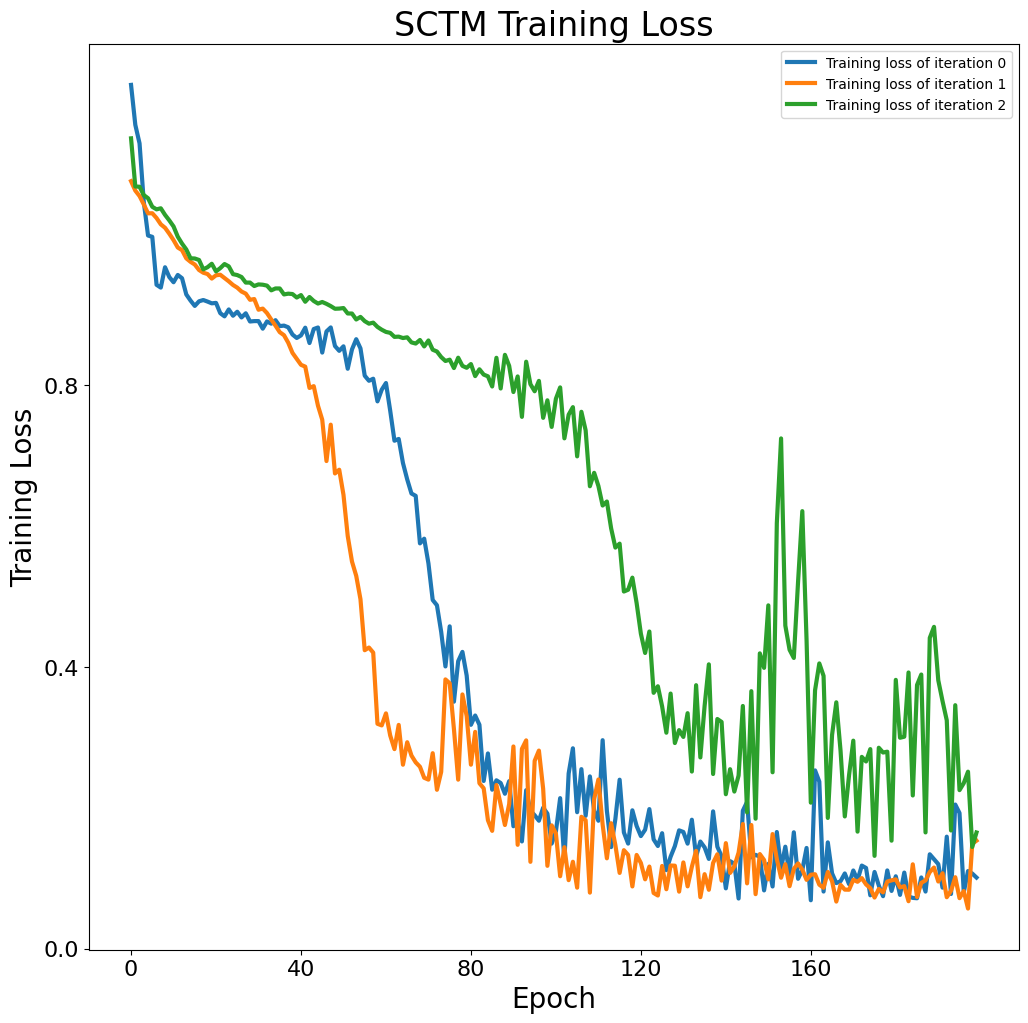

In [10]:
fig, ax = plt.subplots(figsize=(12, 12), dpi = 100)

# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

for i in range(sctm_iterations):
    plt.plot(loss_progress[i], label = "Training loss of iteration " + str(i), linewidth = 3)

plt.ylabel("Training Loss", fontsize = '20')
ax.yaxis.set_ticks(np.arange(0, 1, 0.4))
plt.xlabel("Epoch", fontsize = '20')
ax.xaxis.set_ticks(np.arange(0, reps, 40))
plt.title('SCTM Training Loss', fontsize = '24')
plt.legend()
plt.savefig('SCTM_loss.png')

### Definition of the function that plots Wigner functions.

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

### Obtain the target and learnt states from the quantum decoder.

In [12]:
rho_target = np.outer(target_state, target_state.conj())
rho_learnt = np.outer(learnt_state, learnt_state.conj())

### Plot the target state as a Wigner function.

C:\Users\Bartu\AppData\Local\Temp\ipykernel_13352\2788124896.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


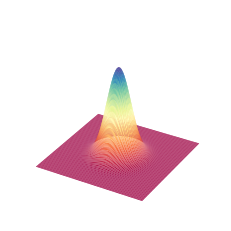

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.17)
ax.set_axis_off()
fig.show()

### Plot the learnt state as a Wigner function.

C:\Users\Bartu\AppData\Local\Temp\ipykernel_13352\4222121820.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


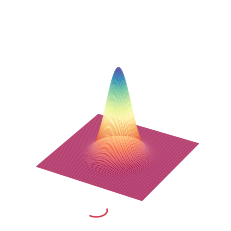

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.17)
ax.set_axis_off()
fig.show()

In [15]:
np.savetxt(save_folder_name + '/x' + str(train_state_select) + '.txt', X)
np.savetxt(save_folder_name + '/p' + str(train_state_select) + '.txt', P)
np.savetxt(save_folder_name + '/w' + str(train_state_select) + '.txt', W)
np.savetxt(save_folder_name +'/encoded_ '+ str(train_state_select) +'.txt', encoded_st)